Instructions for this Program:

Download the numerator ROI's per-pixel-spectrum file from ENVI 64. Then, download denominator ROI's average spectrum as an ASCII file from the wavelength vs I/R graph on ENVI Classic. 

Save these files in the same folder as this program or be sure to specify the file path. Enter the names of the average denominator file for averagedden and the name of the per-pixel-spectrum file for pixelnum. 

set the variable outputs equal to True if you would like file outputs. If you type True, a .csv file with a summary of the data will be exported as well as a .png file of the graphs and a .csv file of the smoothed spectrum. 

The graph and the summary dataframe will be displayed at the end of this notebook. 

Wavelengths are in microns; I/R values, CRC values, and Band depths are unitless

Pixels Dropped: 27
Pixels Kept: 105
     Absorption  Minimum Wavelength  Minimum Wavelength SEM  \
57         1.41                 NaN                     NaN   
65         1.46             1.38175                0.000770   
133        1.91                 NaN                     NaN   
141        1.96             1.90827                0.001263   
179        2.21                 NaN                     NaN   
186        2.26             2.21199                0.000884   

     Minimum Wavelength STDEV  Minimum Value  Average CRC   CRC SEM  \
57                        NaN            NaN          NaN       NaN   
65                   0.007892       1.029584     0.589457  0.002858   
133                       NaN            NaN          NaN       NaN   
141                  0.012940       1.041102     0.682826  0.001694   
179                       NaN            NaN          NaN       NaN   
186                  0.009054       1.041293     0.996062  0.002381   

     CRC Stdev  Band Dep

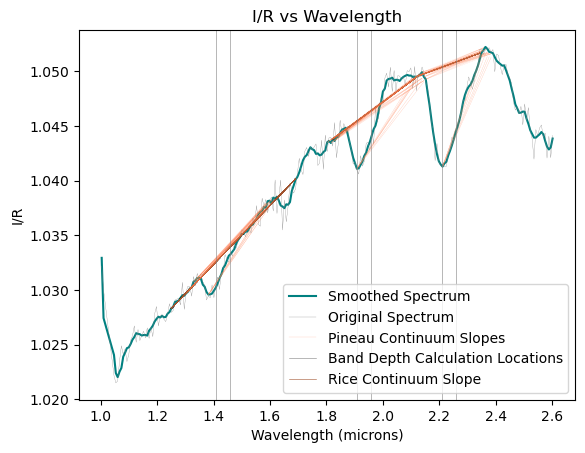

In [1]:
#Imports that are needed to run this program. If you get errors, try pip installing the package in terminal / command prompt
import numpy as np
import pandas as pd
import math
import scipy.signal
import statistics
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

####################### User Inputs #######################

#text file (ACII) as downloaded from ENVI Classic:  Enter the names of your files
averageden = "Example_Denominator.txt"
#.csv file as downloaded from ENVI (not Classic)
pixelnum = "Example_Numerator.csv"
#Would you like there to be output files? type True or False
outputfiles = False
#What you want your output file to be called. Note, the program will add '.txt' and '.csv' to the end of the file name later
outputfilename = "Example_Output"

####################### Code starts here. Avoid making chnges beyond this point #######################

#This section of the code imports, cleans, and re-arranges the files you entered above into a dataframe.

#import denominator file and remove the first several rows that don't contain any data"
dfden = pd.read_csv(averageden, delimiter = "\s+", skiprows = 3,header = None, engine='python')

#Remove any columns that do not contin data.

dfden.columns = ['Wavelength', 'Averaged Denominator']

# Check to see if the data is in microns. If it is not, change units to microns.
if dfden.loc[3,"Wavelength"] > 100:
    dfden["Wavelength"] = dfden["Wavelength"]/1000
    
#import the numerator values and remove rows that don't contian data
df = pd.read_csv(pixelnum, skiprows = 7, delimiter = ",")

#drop columns contianing irrelevent data
df.drop([0], inplace = True)
df.drop(["; File X"," File Y", " Map X"," Map Y"," Lat"," Lon"], axis = 1, inplace = True)

#transpose numerator data frame so they match the format of the denominator data frame
df = df.transpose()
# dfden contains both wavelengths and the denominator average. The df dataframe doesn't have either so we make two columns with nan valus
# so we can insert these values into the df datframe
df.insert(0,"Denominator Average",np.nan)
df.insert(0,"Wavelength", np.nan)

# Remove data that is not between ~1 and ~2.6 micros
#This checks if you have both short and long wavelengths

#If your file has both VNIR and NIR, it will run this part
if dfden.loc[3,"Wavelength"] < .5:
    dfden.drop(dfden.index[315:], inplace = True)
    dfden.drop(dfden.index[:76], inplace = True)
    df.drop(df.index[315:], inplace = True)
    df.drop(df.index[:76], inplace = True)
#If your file just NIR, it will run this instead
else:
    dfden.drop(dfden.index[243:], inplace = True)
    df.drop(df.index[243:], inplace = True)

#add wavelengths and denominator average to the numerator dataframe
for row in range(len(df)):
    df.iloc[row,0] = dfden.iloc[row,0]
    df.iloc[row,1] = dfden.iloc[row,1]
    
#divide all numerator values by the average denominator
for column in range(1,len(df.columns)-1):
    df[column] = df[column]/df["Denominator Average"] 
#remove the denominator average from the dataframe and name the wavelengths column "Wavelength"
df.drop(["Denominator Average"], axis = 1, inplace = True)
df.rename(columns = {"Wavelength":0}, inplace = True)
df = df.reset_index()
df.drop(["index"], axis = 1, inplace = True)

#This copies df to a different memory location so we can make changes to one without chanigng the other
#Each spectrum within df will be changed by adding a savitzky golay filter but ogdf will have the original spectra
ogdf = df.copy(deep=True)

#This applies a savitzky golay filter to every pixel's spectrum.  
for column in range(1,len(df.columns)-1):
    df.iloc[:,column] = scipy.signal.savgol_filter(df.iloc[:,column],11 , 3)

########################### Find Minima ###################################

#Useful wavelengths are useful wavelengths at which to check the band depth according to Rice et al. 2013.
usefulwavelengths = [1.41,1.46,1.91,1.96,2.21,2.26]

#useful indices are the indices at wich the useful wavelength are positioned
usefulindices = []

#find the indices of the useful wavelengths
for i in range(len(usefulwavelengths)):
    for x in range(len(df)):
        #Test to see if the wavelength is close to the useful wavelength
        if np.abs(df.iloc[x,0]-usefulwavelengths[i]) <=.003:
            usefulindices.append(x)

#For each spectrum in df we are going to check for absorptions at 1.4, 1.9, and 2.2. If one of the 
#absoprtions is absent, it is removed from the list (assigned to dropcount). We will also find the 
#location of the minima and add them to their respective lists asssigned below

#initialize the lists described above
min14 = []
min19 = []
min22 = []
dropcount = []
keepcount = []

for column in range(1,len(df.columns)):
    count = 0
    # finds minimum within a certain range of indices
    minimum14 = min(df.iloc[:,column].values.tolist()[usefulindices[0]-10:usefulindices[1]])
    #Finds the index of the minimum
    index14 = (df[df.iloc[:,column] == minimum14].index.values[0])
    #Checks to see if there is an absorption at 1.4
    # For a given range of indices, this function calculates the relative minimum. We want it to consider the entire 
    #range of indices which happens to be 18 indices long which is why order is set to 18.
    minloc = argrelextrema(df.iloc[usefulindices[0]-10:usefulindices[1],column].values, np.less,order=18)[0]
    #There can be multiple minima which we are not interested in keeping so we first check if the length of the list of minima is equal to 1
    #If there is an absorption, add the minimum index to the min14 list
    if (len(minloc) == 1):
        #We also expect the minima to be somewhere in the middle so we have excluded minima that are at the beginning of the range.
        if minloc[0] > 3:
            count += 1
            
    # finds minimum within a certain range of indices
    minimum19 = min(df.iloc[:,column].values.tolist()[usefulindices[2]-10:usefulindices[3]])
    #Finds the index of the minimum
    index19 = df[df.iloc[:,column] == minimum19].index.values[0]
    #Checks to see if there is an absorption at 1.9
    # For a given range of indices, this function calculates the relative minimum. We want it to consider the entire 
    #range of indices which happens to be 18 indices long which is why order is set to 18.
    minloc = argrelextrema(df.iloc[usefulindices[2]-10:usefulindices[3],column].values, np.less,order=18)[0]
    #There can be multiple minima which we are not interested in keeping so we first check if the length of the list of minima is equal to 1
    #If there is an absorption, add the minimum index to the min19 list
    if (len(minloc) == 1):
        #We also expect the minima to be somewhere in the middle so we have excluded minima that are at the beginning of the range.
        if minloc[0] > 3:
            count += 1

    # finds minimum within a certain range of indices
    minimum22 = min(df.iloc[:,column].values.tolist()[usefulindices[4]-10:usefulindices[5]])
    #Finds the index of the minimum
    index22= df[df.iloc[:,column] == minimum22].index.values[0]
    #Checks to see if there is an absorption at 2.2
    # For a given range of indices, this function calculates the relative minimum. We want it to consider the entire 
    #range of indices which happens to be 18 indices long which is why order is set to 18.
    minloc = argrelextrema(df.iloc[usefulindices[4]-10:usefulindices[5],column].values, np.less,order=18)[0]
    #There can be multiple minima which we are not interested in keeping so we first check if the length of the list of minima is equal to 1
    #If there is an absorption, add the minimum index to the min22 list
    if (len(minloc) == 1):
        #We also expect the minima to be somewhere in the middle so we have excluded minima that are at the beginning of the range.
        if minloc[0] > 3:
            count += 1
    #if there is a local minimum in each absorption window, a counter goes up. 
    #If all three counters go up, i.e. all three absorpitons are present, we keep that spectrum and add it to the keepcount
    # We also add the index of the miminum to their respective lists so we can compute the SEM and STDEV
    if count == 3:
        keepcount.append(column)
        min14.append(df.iloc[index14,0])
        min19.append(df.iloc[index19,0])
        min22.append(df.iloc[index22,0])
    else:
        dropcount.append(column)

#Here we actually drop all the columns that don't contin three absorptions from both df and ogdf. 
df.drop(dropcount,axis = 1, inplace = True)
ogdf.drop(dropcount, axis = 1, inplace = True)

print("Pixels Dropped: "+ str(len(dropcount)))
print("Pixels Kept: " + str(len(keepcount)))

#This is the averag of the pre-smoothed spectra
df['average'] = df.loc[:,[c for c in df.columns if c!= 0]].mean(axis=1)
#this is the average spectrum with no smoothing
ogdf["I/RNoise"] = ogdf.loc[:,[c for c in ogdf.columns if c!= 0]].mean(axis=1)
#This is the average spectrum above with a savitzky golay filter applied after the spectra are averaged
ogdf["average"] = scipy.signal.savgol_filter(ogdf['I/RNoise'],11 , 3)

# Calculate standard deviation, SEM, and average minimum position for each absorption
min14stdev = statistics.pstdev(min14)
min14SEM = min14stdev / math.sqrt(len(min14))
average14 = sum(min14) / len(min14)

min19stdev = statistics.pstdev(min19)
min19SEM = min19stdev / math.sqrt(len(min19))
average19 = sum(min19) / len(min19)

min22stdev = statistics.pstdev(min22)
min22SEM = min22stdev / math.sqrt(len(min22))
average22 = sum(min22) / len(min22)

# These are lists of of the SEMs and STDEVs created above
SEMS = [min14SEM,min19SEM,min22SEM]
minstdev = [min14stdev,min19stdev,min22stdev]

######################### Iterables #########################

# Copy all the wavelengths from the datafrome to a list
allwavelength = ogdf[0].to_list()
# Copy all the indices from the dataframe to a list
allindices = [x for x in range(len(ogdf.index))]

########################## Anchor Points ##########################

#These are the anchor points adapted from Pan et al. 2021 & Rice et al. 2013
anchorcenter = [1.32,1.6,1.82,2.13,2.13,2.37]
#Because CRISM measures light at specific wavelengths, they will not exactly equal 
#the anchor points suggested in the paper. Instead, we find the closest wavelength
for x in range(len(allindices)):
    #Test to see if the wavelength is close to the useful wavelength
    if np.abs((ogdf.loc[x,0])-anchorcenter[0]) <=.003:
        #This is a list of the indices three before and after the anchor center to the left of the 1.4 absorption
        firstshort = [x-3,x-2,x-1,x,x+1,x+2,x+3]
    if np.abs(ogdf.loc[x,0]-anchorcenter[1]) <=.003:
        #This is a list of the indices three before and after the anchor center to the right of the 1.4 absorption
        firstlong = [x-3,x-2,x-1,x,x+1,x+2,x+3]
    if np.abs(ogdf.loc[x,0]-anchorcenter[2]) <=.003:
        #This is a list of the indices three before and after the anchor center to the left of the 1.9 absorption
        secondshort = [x-3,x-2,x-1,x,x+1,x+2,x+3]
    if np.abs(ogdf.loc[x,0]-anchorcenter[3]) <=.003:
        #This is a list of the indices three before and after the anchor center to the right of the 1.9 absorption
        secondlong = [x-3,x-2,x-1,x,x+1,x+2,x+3]
    if np.abs(ogdf.loc[x,0]-anchorcenter[4]) <=.003:
        #This is a list of the indices three before and after the anchor center to the left of the 2.2 absorption
        thirdshort = [x-3,x-2,x-1,x,x+1,x+2,x+3]
    if np.abs(ogdf.loc[x,0]-anchorcenter[5]) <=.003:
        #This is a list of the indices three before and after the anchor center to the right of the 2.2 absorption
        thirdlong = [x-3,x-2,x-1,x,x+1,x+2,x+3]

########################## Continuum Slopes ##########################
#The objective of this section is to create lines forming the proxy continuum over the absorptions. Each anchor to the left of the 
#absorption will be paired with each anchor to the right of the absorption for a total of 49 proxy continuum lines.

#This is a list of all the anchor pionts as difined above as well as a string to be included in column titles
anchors = [(firstshort,firstlong,"1.4 Continuum "),(secondshort,secondlong, "1.9 Continuum "),(thirdshort,thirdlong, "2.2 Continuum ")]
#This is a dictionary for storying the continuum lines which we will add to the dataframe later.
continuum_dict = {}
for anchor in anchors:    
    count1 = 0
    for i in anchor[0]:
        count2 = 0
        count1 += 1
        for x in anchor[1]:
            count2 += 1
            rise = ogdf["average"][i]-ogdf["average"][x]
            run = ogdf[0][i] - ogdf[0][x]
            slope = rise/run
            #This creates an empty numpy array that is the same length as the data frame
            continuum = np.full(len(ogdf[0]), np.nan)
            #this adds points forming the continuum line to the numpy array according to y = mx+b (but just within the range of the absorption)
            for r in range (i,x):
                continuum[r] = slope * (ogdf.loc[r,0] - ogdf[0][i]) + ogdf["average"][i]
            continuum_dict[anchor[2] + str(count1) + "," + str(count2)] = continuum
#This transforms the numpy array into a new dataframe
continuum_df = pd.DataFrame(continuum_dict)
#This adds the new dataframe containing the continuum lines to the original data frame
ogdf = pd.concat([ogdf, continuum_df],axis = 1)

########################## Band Depths Slopes ##########################

#For band depth, we just use the following values for the "shoulders" / "anchor points" in Table 10 from  Rice et al. (2013). 

shoulder = [1.25,1.7,1.820,2.125,2.125,2.350]
shoulderindex = []
slopedict = {}
for i in range(len(shoulder)):
    for x in range(len(allindices)):
        #Test to see if the wavelength is close to the useful wavelength
        if np.abs(ogdf.loc[x,0]-shoulder[i]) <=.003:
            # if it is close to the useful wavelength, add the useful wavelength and the corresponding band depth to the dataframe
            shoulderindex.append(x)
#Now we have a list of all the shoulder indices according to Rice called shoulderindex

#Add the band depth continuum slope to the dataframe
riceslopes = [("1.4 Band Depth Slope", 0), ("1.9 Band Depth Slope",2), ("2.2 Band Depth Slope",4)]
for i in riceslopes:
    ogdf[i[0]] = np.nan
    rise = ogdf["average"][shoulderindex[i[1]]] - ogdf["average"][shoulderindex[i[1]+1]]
    run = ogdf[0][shoulderindex[i[1]]] - ogdf[0][shoulderindex[i[1]+1]]
    slope = rise/run
    #This creates an empty numpy array that is the same length as the data frame
    slopes = np.full(len(ogdf[0]), np.nan)
    for r in range (shoulderindex[i[1]],shoulderindex[i[1]+1]):
        ogdf.loc[r,i[0]] = slope * (ogdf.loc[r,0] - ogdf[0][shoulderindex[i[1]]]) +ogdf["average"][shoulderindex[i[1]]]

########################## Rice Band Depths ##########################

usefulwavelengths = [1.41,1.46,1.91,1.96,2.21,2.26]

usefulindices = []
ogdf["Absorption"] = np.nan

# Find The closest actaul wavelength to the useful wavelengths
for i in range(len(usefulwavelengths)):
    for x in range(len(allindices)):
        #Test to see if the wavelength is close to the useful wavelength
        if np.abs(ogdf.loc[x,0]-usefulwavelengths[i]) <=.003:
            # if it is close to the useful wavelength, add the useful wavelength to the dataframe
            ogdf.loc[x,"Absorption"] = usefulwavelengths[i]
            usefulindices.append(x)

banddepths = []
for i in riceslopes:
    banddepths.append((1-ogdf["average"]/ogdf[i[0]])[usefulindices[i[1]]])
    banddepths.append((1-ogdf["average"]/ogdf[i[0]])[usefulindices[i[1]+1]])
        
# print(ogdf)
########################### Find Minima ###################################
#Before we calculated the minimum of each spectrum. Now we find the minima of the averaged spectrum
# print(ogdf["average"])
#This checks the averaged spectrum for the minimum between a range of indices
minimum14 = min(ogdf["average"].values.tolist()[usefulindices[0]-4:usefulindices[1]])
#This finds the index of the minimum
min14 = ogdf[ogdf["average"] == minimum14].index.values[0]
#This checks the averaged spectrum for the minimum between a range of indices
minimum19 = min(ogdf["average"].values.tolist()[usefulindices[2]-4:usefulindices[3]])
#This finds the index of the minimum
min19 = ogdf[ogdf["average"] == minimum19].index.values[0]
#This checks the averaged spectrum for the minimum between a range of indices
minimum22 = min(ogdf["average"].values.tolist()[usefulindices[4]-4:usefulindices[5]])
#This finds the index of the minimum
min22 = ogdf[ogdf["average"] == minimum22].index.values[0]

minima = [min14,min19,min22] 
# print(minima)
########################### ATC Lines ###########################
#This is a similar process to creating the proxy continuum lines but this time we are making lines from the minimum the the long wave anchor points

#This is a list of the anchor pionts as difined above as well as a string to be included in column titles and the indes of the respective minimum
longanchors = [(firstlong,"1.4 MinSlope ",minima[0]),(secondlong, "1.9 MinSlope ", minima[1]),(thirdlong, "2.2 MinSlope ", minima[2])]
#This is a dictionary for storying the ATC lines which we will add to the dataframe later.
atc_dict = {}
for anchor in longanchors:
    count1 = 0
    for i in anchor[0]:
        count1 += 1
        rise = ogdf.loc[anchor[2],"average"]-ogdf.loc[i,"average"]
        run = ogdf.loc[anchor[2],0] - ogdf.loc[i,0]
        slope = rise/run
        #This creates an empty numpy array that is the same length as the data frame
        atc = np.full(len(ogdf[0]), np.nan)
        #this adds points forming the ATC line to the numpy array according to y = mx+b
        for r in range (anchor[2],i):
            atc[r] = slope * (ogdf.loc[r,0] - ogdf.loc[anchor[2],0]) + ogdf.loc[anchor[2],"average"]
        atc_dict[anchor[1] + str(count1)] = atc
        
#This transforms the numpy array into a new dataframe
atc_df = pd.DataFrame(atc_dict)
#This adds the new dataframe containing the continuum lines to the original data frame
ogdf = pd.concat([ogdf, atc_df], axis = 1)
########################## Concavity Ratio ##########################
#The purpose of this section is to calculate the concavity ratio (CRC) for each absorption. The CRC of the 2.2 is not 
#very helpful for this kind of analysis but it is included just in case someone needs it.

#We calculate the CRC between each ATC line and each proxy continuum line and then take the average

#1.4 Concavity ratio
#These lists will contain all the calculated CRC values
CRC14 = []
CRC19 = []
CRC22 = []
count = 0

#We cycle throgh each anchor point on either side of the absorption to calculate each 
for i in range(1,8):
    for x in range(1,8):
        for k in range(1,8):
            count += 1
            continuum1 = "1.4 Continuum " + str(i) + "," + str(x)
            minslope1 = "1.4 MinSlope " + str(k)
            Rc1 = ogdf.loc[usefulindices[1],continuum1]
            Rs1 = ogdf.loc[usefulindices[1],"average"]
            Ratc1 = ogdf.loc[usefulindices[1],minslope1]
        
            CRC14.append((Rc1-Rs1) / (Rc1-Ratc1))
            
            continuum2 = "1.9 Continuum " + str(i) + "," + str(x)
            minslope2 = "1.9 MinSlope " + str(k)
            Rc2 = ogdf.loc[usefulindices[3],continuum2]
            Rs2 = ogdf.loc[usefulindices[3],"average"]
            Ratc2 = ogdf.loc[usefulindices[3],minslope2]

            CRC19.append((Rc2-Rs2) / (Rc2-Ratc2))

            continuum3 = "2.2 Continuum " + str(i) + "," + str(x)
            minslope3 = "2.2 MinSlope " + str(k)
            Rc3 = ogdf.loc[usefulindices[5],continuum3]
            Rs3 = ogdf.loc[usefulindices[5],"average"]
            Ratc3 = ogdf.loc[usefulindices[5],minslope3]

            CRC22.append((Rc3-Rs3) / (Rc3-Ratc3))
    
# print(CRC14)      
average14CRC = sum(CRC14)/len(CRC14)
stdev14 = statistics.pstdev(CRC14)
SEMCRC14 = stdev14 / math.sqrt(count)

average19CRC = sum(CRC19)/len(CRC19)
stdev19 = statistics.pstdev(CRC19)
SEMCRC19 = stdev19 / math.sqrt(count)

average22CRC = sum(CRC22)/len(CRC22)
stdev22 = statistics.pstdev(CRC22)
SEMCRC22 = stdev22 / math.sqrt(count)

CRC = [average14CRC,average19CRC,average22CRC]
SEMCRC = [SEMCRC14,SEMCRC19,SEMCRC22]
STDEVCRC = [stdev14,stdev19,stdev22]


########################## Outputs ##########################

outputs = [(1.46, 0), (1.96, 1), (2.26, 2)]
ricebanddepths = [(1.41,0), (1.46, 1), (1.91, 2), (1.96, 3), (2.21, 4), (2.26, 5)]

#Create new columns in df with our final vaues
ogdf["Minimum Position"] = np.nan
ogdf["Minimum Value"] = np.nan
ogdf["Average CRC"] = np.nan
ogdf["SEM"] = np.nan
ogdf["CRC Stdev"] = np.nan
ogdf["Band Depth (Rice)"] = np.nan
ogdf["Minimum Wavelength SEM"] = np.nan
ogdf["Minimum Wavelength STDEV"] = np.nan

#Enter data in the columns made aboved
for i in outputs:
    ogdf.loc[ogdf['Absorption'] == i[0],'Minimum Wavelength'] = ogdf.loc[minima[i[1]],0]
    ogdf.loc[ogdf['Absorption'] == i[0],'Minimum Wavelength SEM'] = SEMS[i[1]]
    ogdf.loc[ogdf['Absorption'] == i[0],'Minimum Wavelength STDEV'] = minstdev[i[1]]
    ogdf.loc[ogdf['Absorption'] == i[0],'Minimum Value'] = ogdf.loc[minima[i[1]],"average"]
    ogdf.loc[ogdf['Absorption'] == i[0],'Average CRC'] = CRC[i[1]]
    ogdf.loc[ogdf['Absorption'] == i[0],'CRC SEM'] = SEMCRC[i[1]]
    ogdf.loc[ogdf['Absorption'] == i[0],'CRC Stdev'] = STDEVCRC[i[1]]
    
for i in ricebanddepths:
    ogdf.loc[ogdf['Absorption'] == i[0],'Band Depth (Rice)'] = banddepths[i[1]]
########################### Plot and Save ###########################

#This section creates the plots with all the information above. also formatting etc.
%matplotlib inline
focused = ogdf[~ogdf['Absorption'].isnull()]  
focused = focused[["Absorption","Minimum Wavelength","Minimum Wavelength SEM","Minimum Wavelength STDEV", "Minimum Value", "Average CRC","CRC SEM","CRC Stdev","Band Depth (Rice)"]]
print(focused)   

fig = plt.figure(facecolor=(1, 1, 1))
plt.plot(ogdf[0], ogdf['average'], c = "teal", label = "Smoothed Spectrum")
plt.plot(ogdf[0], ogdf['I/RNoise'], c = "gray",linewidth = .2, label = "Original Spectrum")

for r in range(shoulderindex[0],shoulderindex[1]):
    plt.plot(ogdf[0],ogdf["1.4 Band Depth Slope"], c = "sienna", linewidth = .4)
    
for r in range(shoulderindex[2],shoulderindex[3]):
    plt.plot(ogdf[0],ogdf["1.9 Band Depth Slope"], c = "sienna", linewidth = .4)
    
for r in range(shoulderindex[4],shoulderindex[5]):
    plt.plot(ogdf[0],ogdf["2.2 Band Depth Slope"], c = "sienna", linewidth = .4)

for i in range(1,8):
    for x in range(1,8):
        continuum = "1.4 Continuum " + str(i) + "," + str(x)
        plt.plot(ogdf[0],ogdf[continuum], c = "coral", linewidth = .05)

for i in range(1,8):
    for x in range(1,8):
        continuum = "1.9 Continuum " + str(i) + "," + str(x)
        plt.plot(ogdf[0],ogdf[continuum], c = "coral", linewidth = .05 )
        
for i in range(1,8):
    for x in range(1,8):
        continuum = "2.2 Continuum " + str(i) + "," + str(x)
        plt.plot(ogdf[0],ogdf[continuum], c = "coral", linewidth = .05 )
        
for i in range(1,8):
    slope = "1.4 MinSlope " + str(i)
    plt.plot(ogdf[0],ogdf[slope], c = "coral", linewidth = .1 )

for i in range(1,8):
    slope = "1.9 MinSlope " + str(i)
    plt.plot(ogdf[0],ogdf[slope], c = "coral", linewidth = .1 )

for i in range(1,8):
    slope = "2.2 MinSlope " + str(i)
    plt.plot(ogdf[0],ogdf[slope], c = "coral", linewidth = .1 )
for length in usefulwavelengths:
    plt.axvline(x = length, c = "gray", linewidth = .4)
    
plt.plot(np.nan,np.nan, c = "coral",linewidth = .1, label = "Pineau Continuum Slopes") 
plt.plot(np.nan,np.nan, c = "gray",linewidth = .4, label = "Band Depth Calculation Locations")
plt.plot(np.nan,np.nan, c = "sienna",linewidth = .4, label = "Rice Continuum Slope")

plt.legend()
    
plt.xlabel("Wavelength (microns)")
plt.ylabel("I/R")
plt.title("I/R vs Wavelength")
plt.legend()

#Save files for later use if you set the variable outputs equal to True


if outputfiles ==True:
    plt.savefig(outputfilename+".svg", format = "svg", dpi = 1200)
    focused.to_csv(outputfilename+'.csv', index=False)
    ogdf.to_csv(outputfilename+'Smoothed.csv', columns = [0,"average"], index = False)
    ogdf.to_csv(outputfilename+'Averaged.csv', columns = [0,"I/RNoise"],index = False)
    